# Reproduction of results from Prem et al., 2022 (doi: 10.3847/PSJ/ac7ced)

Contents
1. Isothermal analysis of 28 µm enstatite (multiple emission angles)
2. Thermal gradient in enstatite, comparison to isothermal case. 
3. Rough surface (hemispherical crater) isothermal, and non-isothermal cases. 

## Setup and Imports

In [40]:
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Import thermal model components
from core.config_manager import ConfigManager, create_default_base_config
from core.thermal_simulation import ThermalSimulator
from modelmain import Simulator
from config import SimulationConfig
from modelmain import fit_blackbody_wn_banded, max_btemp_blackbody, emissionT

from radiance_processor import calculate_radiances_from_results, recompute_radiance_with_angles


# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2

print("Imports completed successfully!")

Imports completed successfully!


## Create and Load Base Simulation Configuration

Create and load in a default config file. 

In [41]:
# Option 1: Create a new default configuration
config_path = "../configs/base_configs/analysis_template.yaml"

# Create config directory if it doesn't exist
os.makedirs(os.path.dirname(config_path), exist_ok=True)

# Create default configuration for analysis
create_default_base_config(config_path)

# Load the configuration
config_manager = ConfigManager(config_path)

# Create base configuration
base_config = config_manager.create_config()

print(f"Configuration created at: {config_path}")
print(f"Loaded configuration.")


Default configuration saved to: ../configs/base_configs/analysis_template.yaml
Configuration created at: ../configs/base_configs/analysis_template.yaml
Loaded configuration.


## Run Isothermal Spectrum Simulation



In [ ]:
# Modify base configuration for our analysis
settings = {
    'diurnal': False,                       # Steady state simulation
    'sun': False,                           # Include solar heating
    'T_fixed': True,                        # Temperature is fixed, prevents thermal evolution
    'compute_observer_radiance': False,      # Compute radiance outputs. 
    'thermal_evolution_mode': 'two_wave',   #Run thermal evolution later with broadband vis (turned off) and broadband thermal. 
    'RTE_solver': 'hapke',
    'output_radiance_mode': 'hybrid',       #Compute spectral radiance in thermal only. 
    'observer_mu': 0.5,                     # Observer zenith angle (0 for nadir)
    'Et': 7000.0,                          # Mean extinction coefficient. For phi=0.37, 50300. For phi=0.60, 81600. 
    'ssalb_therm': 0.62,                     # Single scattering albedo for thermal radiation (average from mie code)
    'g_therm': 0.75,                         # Asymmetry parameter for thermal radiation (average from mie code)
    'R_base': 0.0,                          # Global reflectivity value for substrate     
    'disort_space_temp': 0.0,              # Cold shroud temperature
    'k_dust': 4.2e-4,                       # Phonon thermal conductivity of dust (W/m/K)
    'single_layer': True,                   # Use single-layer model
    'dust_thickness': 0.10,                # 10 cm
    'T_bottom': 250,                        # Sample base fixed at 500 K
    'bottom_bc': 'dirichlet',               # Bottom boundary condition (fixed temperature)
    'fill_frac': 0.37,                      #Fill fraction for particles. 
    'radius': 14.e-6,                       #Particle radius in meters.
    'mie_file_out': '/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/enst_300K_mie_combined.txt',  # Mie file for output
    'wn_bounds_out': '/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/enst_300k_wn_bounds.txt',  # Wavenumber bounds for output files,
    'nstr_out': 16,                # Number of streams for output
    'nmom_out': 16                # Number of moments for output
}

# Create configuration with overrides
config1 = config_manager.create_config(settings)

print("Running baseline simulation...")
print(f"Configuration: Et={config1.Et}, k_dust={config1.k_dust}, thickness={config1.dust_thickness}m")

# Run simulation
sim1 = Simulator(config1)
T_out1, phi_vis1, phi_therm1, T_surf1, t_out1 = sim1.run()

observer_angles = [0, 15, 30, 45, 60, 75]
thermal_results = (T_out1, T_surf1, t_out1)
multi_angle_results = calculate_radiances_from_results(
    thermal_results, config1, observer_angles=observer_angles
)

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

Running baseline simulation...
Configuration: Et=7000.0, k_dust=0.00042, thickness=0.005m
Time step: 0.110240 s, Steps per day: 140149
Non-diurnal step 0, time=0.00s
Simulation completed in 0.00 s
Time step: 0.110240 s, Steps per day: 140149
Computing surface radiances for 6 observers and 1 time points...
  Observer 1/6 (mu=1.000, angle=0.0°)
  Observer 2/6 (mu=0.966, angle=15.0°)
  Observer 3/6 (mu=0.866, angle=30.0°)
  Observer 4/6 (mu=0.707, angle=45.0°)
  Observer 5/6 (mu=0.500, angle=60.0°)
  Observer 6/6 (mu=0.259, angle=75.0°)
Surface radiance calculation completed.
Simulation completed! Output shape: (75, 1)
Time range: 0 to 0 seconds
Surface temperature range: 250.0 to 250.0 K


## Plot isothermal spectrum

No temperature gradient, approximate for an ambient lab measurement. 

250.01854461269917
249.8966665351204
249.7379596891803
249.83348979767305
250.0915240465644
249.17363073741967


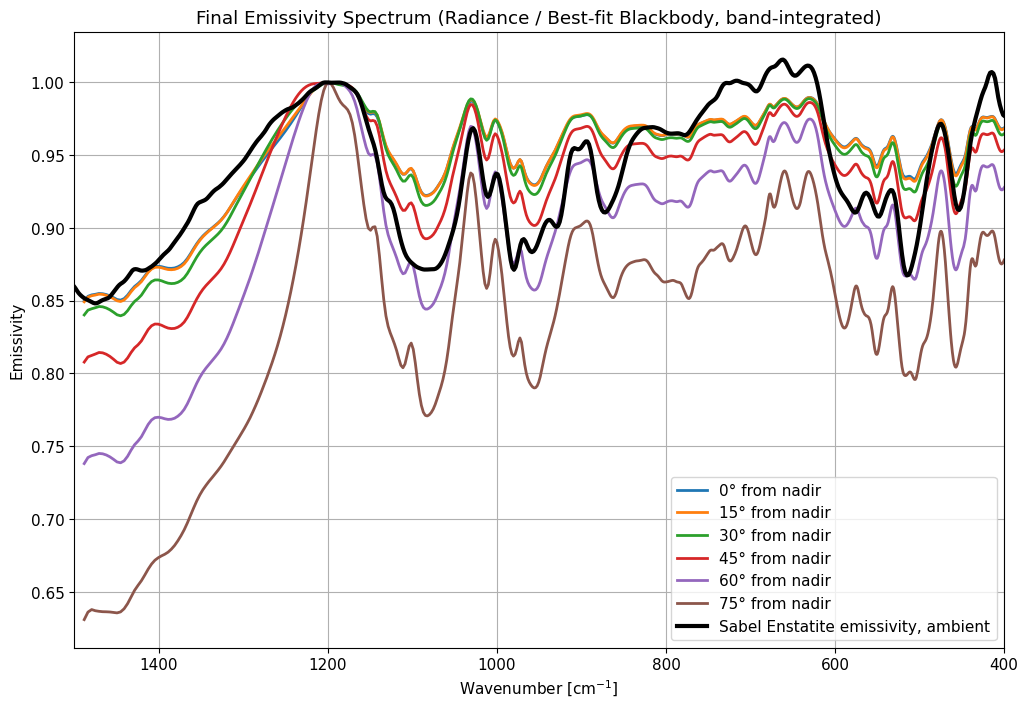

In [73]:
# wn = sim1.wavenumbers_out  # [cm^-1], band centers
# final_rad = sim1.radiance_out[:, -1]  # Final time step
# ir_cutoff = np.argmin(np.abs(wn - 1500))  # cm^-1, cutoff for IR bands
# # Read bin edges from config
# wn_bounds = np.sort(np.loadtxt(sim1.cfg.wn_bounds_out))
# #T_fit, B_fit, emiss_spec, wn_BB = fit_blackbody_wn_banded(sim,wn_bounds, final_rad)
# T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim1,wn_bounds, final_rad)
# emiss_spec = final_rad/B_fit
# idx1 = np.argmin(np.abs(wn - 900))
# idx2 = np.argmin(np.abs(wn - 1700))
# ds_cf_emis = emiss_spec[idx1:idx2+1].max()  # Max emissivity in this range

# Extract radiance data for plotting
angles = multi_angle_results['observer_angles_deg']
wn = multi_angle_results['wavenumbers']
radiances = multi_angle_results['radiance_thermal']

ir_cutoff = np.argmin(np.abs(wn - 1500))  # cm^-1, cutoff for IR bands
wn_bounds = np.sort(np.loadtxt(sim1.cfg.wn_bounds_out))
T_fit, B_fit_first, btemps, wn_BB = max_btemp_blackbody(sim1, wn_bounds, radiances[0,:,-1])


# Calculate emissivity for each angle (using same approach as before)
for i, angle in enumerate(angles):
    final_rad_angle = radiances[i, :, -1]  # Final time step
    
    # Calculate blackbody fit for this angle's radiance
    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim1, wn_bounds, final_rad_angle)
    emiss_spec_angle = final_rad_angle / B_fit
    print(T_fit)
    
    # Normalize emissivity
    idx1 = np.argmin(np.abs(wn - 900))
    idx2 = np.argmin(np.abs(wn - 1700))
    cf_emis = emiss_spec_angle[idx1:idx2+1].max()
    
    # Plot normalized emissivity spectrum
    plt.plot(wn[:ir_cutoff], emiss_spec_angle[:ir_cutoff] + 1 - cf_emis, 
             label=f'{angle:.0f}° from nadir', linewidth=2)


substrate = np.loadtxt('/Users/ryan/Research/RT_models/RT_thermal_model/Optical_props/sabel_enstatite.txt')
idx1 = np.argmin(np.abs(substrate[:,0] - 1700))
idx2 = np.argmin(np.abs(substrate[:,0] - 900))
substrate_cf = substrate[idx1:idx2,1].max()


#plt.figure()
#plt.plot(wn_BB, emiss_spec + otes_cf_emis - bbfit_cf_emis, label=f'Emissivity (T_fit={T_fit:.1f} K)')
#plt.plot(multi_wn_BB, multi_emiss_spec, label=f'Mixture Emissivity (T_fit={multi_T_fit})')
#plt.plot(wn[:ir_cutoff], emiss_spec[:ir_cutoff]+1-ds_cf_emis, label=f'Isothermal disort radiance -> emissivity',linewidth=2)
plt.plot(substrate[:,0], substrate[:,1]+1-substrate_cf, label='Sabel Enstatite emissivity, ambient',linewidth=3,c='black')
#plt.plot(wn[:ir_cutoff],emiss_spec_flux[:ir_cutoff]+1-ds_cf_emis_flux, label=f'Isothermal disort flux emissivity (T_fit={T_fit_flux:.1f} K)', linestyle='--', linewidth=2)
plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Emissivity')
plt.xlim([400,1500])
plt.title('Final Emissivity Spectrum (Radiance / Best-fit Blackbody, band-integrated)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

## Run thermal evolution model for lunar environmental chamber conditions. 



In [74]:

# Allow thermal evolution now. 
settings['T_fixed'] = False
settings['sun'] = False
settings['steady_tol'] = 1.5e-4  # Convergence tolerance for steady state (K)
settings['dtfac'] = 150.0
config2 = config_manager.create_config(settings)

# Run simulation
sim2 = Simulator(config2)
T_out2, phi_vis2, phi_therm2, T_surf2, t_out2 = sim2.run()

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

Time step: 0.110240 s, Steps per day: 140149
Non-diurnal step 0, time=0.00s
[Steady-state check] step 200, max |T - T_ext| = 3.238e+00 K
[Steady-state check] step 400, max |T - T_ext| = 1.876e+00 K
[Steady-state check] step 600, max |T - T_ext| = 1.316e+00 K
[Steady-state check] step 800, max |T - T_ext| = 1.110e+00 K
[Steady-state check] step 1000, max |T - T_ext| = 9.331e-01 K
Non-diurnal step 1000, time=110.24s
[Steady-state check] step 1200, max |T - T_ext| = 7.838e-01 K
[Steady-state check] step 1400, max |T - T_ext| = 6.569e-01 K
[Steady-state check] step 1600, max |T - T_ext| = 6.034e-01 K
[Steady-state check] step 1800, max |T - T_ext| = 5.534e-01 K
[Steady-state check] step 2000, max |T - T_ext| = 5.073e-01 K
Non-diurnal step 2000, time=220.48s
[Steady-state check] step 2200, max |T - T_ext| = 4.648e-01 K
[Steady-state check] step 2400, max |T - T_ext| = 4.257e-01 K
[Steady-state check] step 2600, max |T - T_ext| = 3.897e-01 K
[Steady-state check] step 2800, max |T - T_ext| = 

## Plot vacuum thermal gradient

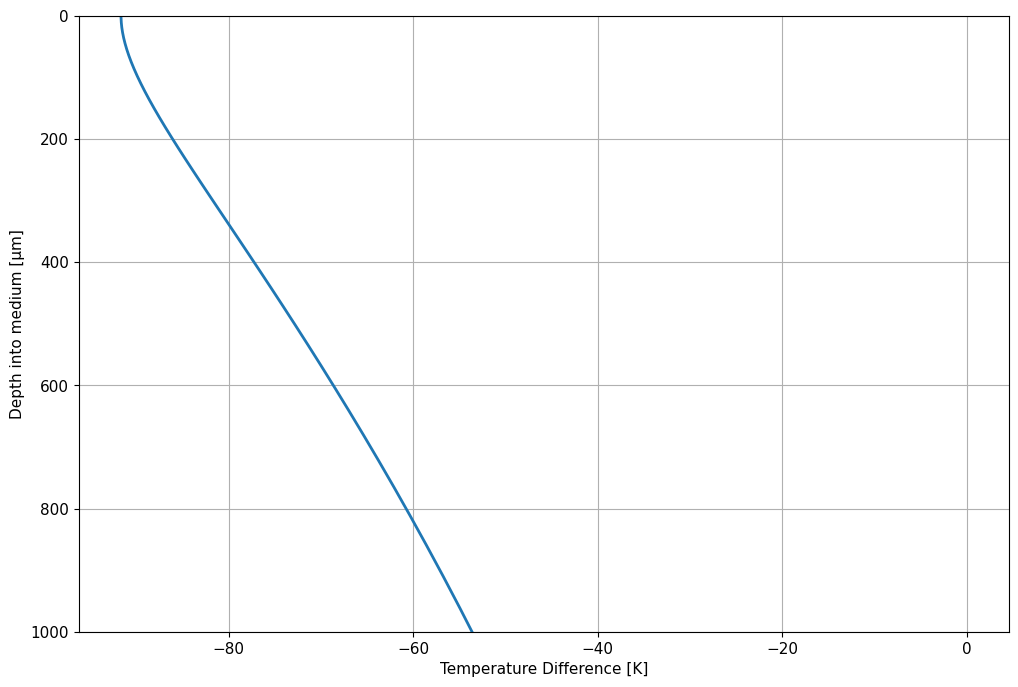

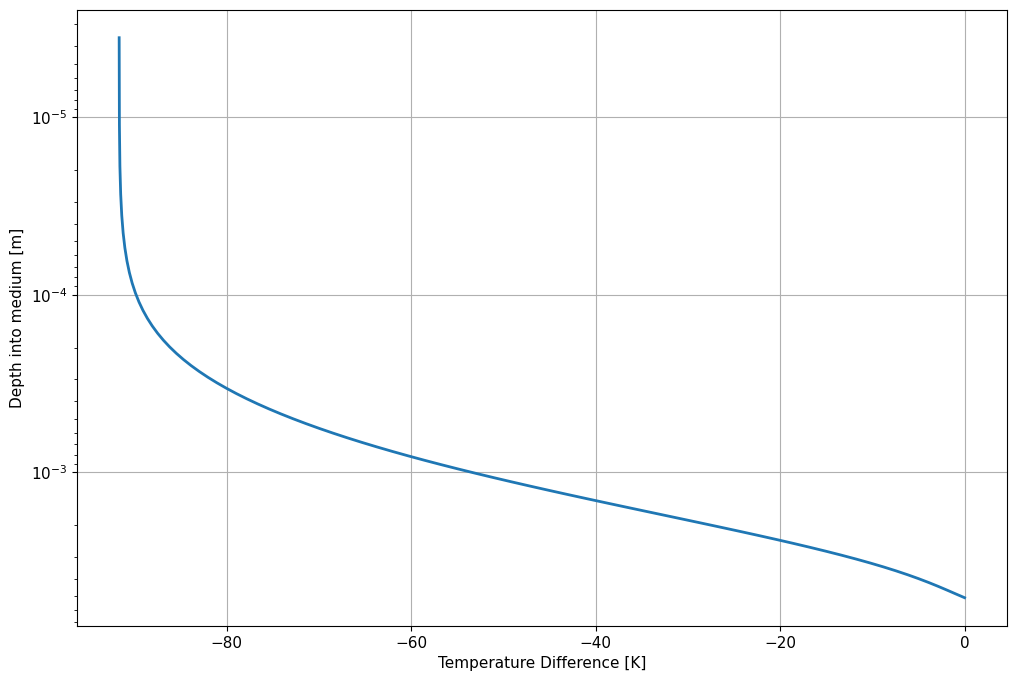

In [75]:
plt.plot(T_out2[1:,-1]-sim2.cfg.T_bottom ,sim2.grid.x[1:]/sim2.cfg.Et * 1e6)
plt.ylabel('Depth into medium [µm]')
plt.xlabel('Temperature Difference [K]')
plt.ylim([0,1000])
#plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

plt.semilogy(T_out2[1:,-1]-sim2.cfg.T_bottom ,sim2.grid.x[1:]/sim2.cfg.Et)
plt.ylabel('Depth into medium [m]')
plt.xlabel('Temperature Difference [K]')
#plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

## Plot vacuum spectrum

Time step: 0.110240 s, Steps per day: 140149
Computing surface radiances for 6 observers and 1 time points...
  Observer 1/6 (mu=1.000, angle=0.0°)
  Observer 2/6 (mu=0.966, angle=15.0°)
  Observer 3/6 (mu=0.866, angle=30.0°)
  Observer 4/6 (mu=0.707, angle=45.0°)
  Observer 5/6 (mu=0.500, angle=60.0°)
  Observer 6/6 (mu=0.259, angle=75.0°)
Surface radiance calculation completed.
Computing surface radiances for 1 observers and 1 time points...
  Observer 1/1 (mu=0.500, angle=60.0°)
Surface radiance calculation completed.


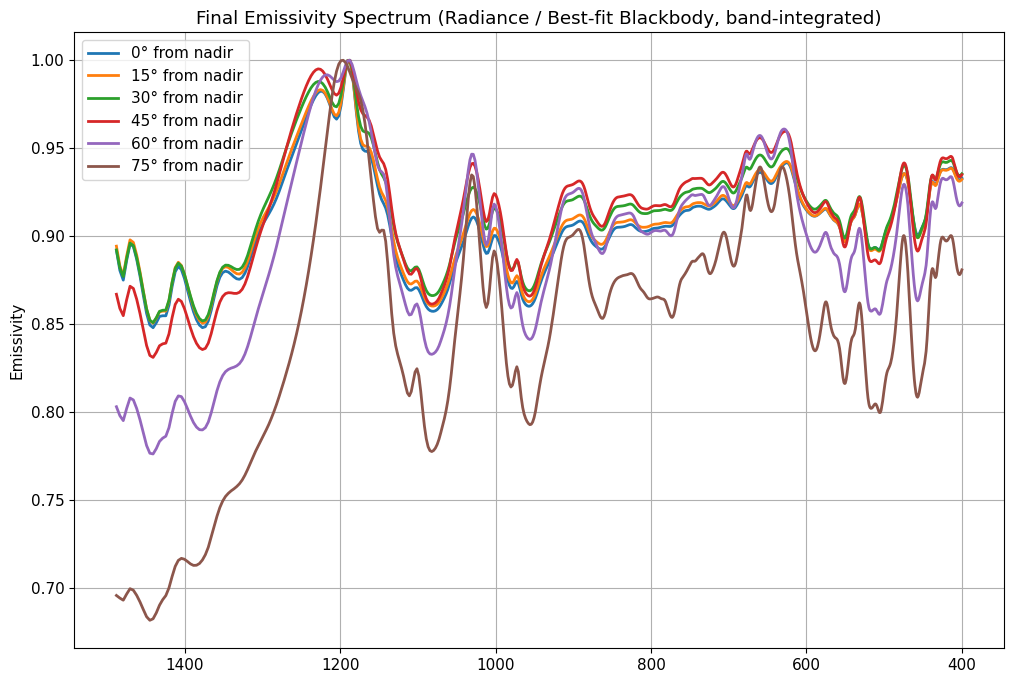

In [76]:

observer_angles = [0, 15, 30, 45, 60, 75]
thermal_results2 = (T_out2, T_surf2, t_out2)
multi_angle_results2 = calculate_radiances_from_results(
    thermal_results2, config2, observer_angles=observer_angles
)


# Extract radiance data for plotting
angles = multi_angle_results2['observer_angles_deg']
wn = multi_angle_results2['wavenumbers']
radiances = multi_angle_results2['radiance_thermal']

wn = sim2.wavenumbers_out  # [cm^-1], band centers
ir_cutoff = np.argmin(np.abs(wn - 1500))  # cm^-1, cutoff for IR bands
wn_bounds = np.sort(np.loadtxt(sim2.cfg.wn_bounds_out))

# Calculate emissivity for each angle (using same approach as before)
for i, angle in enumerate(angles):
    final_rad_angle = radiances[i, :, -1]  # Final time step
    
    # Calculate blackbody fit for this angle's radiance
    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim2, wn_bounds, final_rad_angle)
    emiss_spec_angle = final_rad_angle / B_fit
    
    # Normalize emissivity
    idx1 = np.argmin(np.abs(wn - 900))
    idx2 = np.argmin(np.abs(wn - 1700))
    cf_emis = emiss_spec_angle[idx1:idx2+1].max()
    
    # Plot normalized emissivity spectrum
    plt.plot(wn[:ir_cutoff], emiss_spec_angle[:ir_cutoff] + 1 - cf_emis, 
             label=f'{angle:.0f}° from nadir', linewidth=2)

plt.ylabel('Emissivity')
plt.title('Final Emissivity Spectrum (Radiance / Best-fit Blackbody, band-integrated)')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

#Single observer angle plot comparison


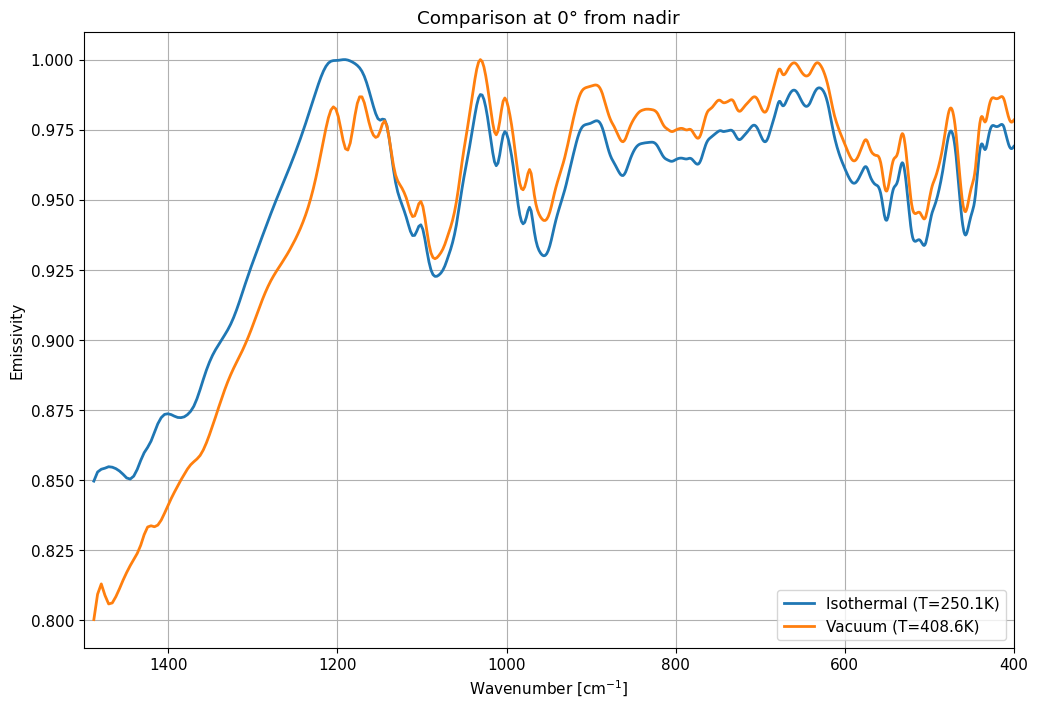

In [68]:
# Single angle comparison between isothermal and vacuum cases
angle_idx = 0  # Use first angle (0° from nadir)
wn = multi_angle_results['wavenumbers']
ir_cutoff = np.argmin(np.abs(wn - 1500))
wn_bounds = np.sort(np.loadtxt(sim2.cfg.wn_bounds_out))

# Get radiances for both cases at the chosen angle
iso_rad = multi_angle_results['radiance_thermal'][angle_idx, :, -1]
vac_rad = multi_angle_results2['radiance_thermal'][angle_idx, :, -1]

# Calculate emissivities
T_fit_iso, B_fit_iso, _, _ = max_btemp_blackbody(sim1, wn_bounds, iso_rad)
T_fit_vac, B_fit_vac, _, _ = max_btemp_blackbody(sim2, wn_bounds, vac_rad)

emiss_iso = iso_rad / B_fit_iso
emiss_vac = vac_rad / B_fit_vac

# Normalize emissivities
idx1 = np.argmin(np.abs(wn - 900))
idx2 = np.argmin(np.abs(wn - 1700))
cf_emis_iso = emiss_iso[idx1:idx2+1].max()
cf_emis_vac = emiss_vac[idx1:idx2+1].max()

# Plot comparison
plt.figure(figsize=(12, 8))
plt.plot(wn[:ir_cutoff], emiss_iso[:ir_cutoff] + 1 - cf_emis_iso, 
         label=f'Isothermal (T={T_fit_iso:.1f}K)', linewidth=2)
plt.plot(wn[:ir_cutoff], emiss_vac[:ir_cutoff] + 1 - cf_emis_vac, 
         label=f'Vacuum (T={T_fit_vac:.1f}K)', linewidth=2)

plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Emissivity')
plt.title(f'Comparison at {angles[angle_idx]:.0f}° from nadir')
plt.legend()
plt.grid(True)
plt.xlim([400, 1500])
plt.gca().invert_xaxis()
plt.show()

## Run Crater case (fixed temperature)

In [38]:
# Allow thermal evolution now. 
settings['T_fixed'] = True
settings['crater'] = True
config3 = config_manager.create_config(settings)

# Run simulation
sim3 = Simulator(config3)
T_out3, phi_vis3, phi_therm3, T_surf3, t_out3 = sim3.run()

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

print("Computing crater radiance using ")
observer_vectors = [[0, 0, 1], [1.0, 0, 0.58]]  # 60° emission angle. 
crater_results = calculate_radiances_from_results(
    sim3, surface_type='crater', observer_vectors=observer_vectors
)

smooth_results = calculate_radiances_from_results(
    sim3, surface_type='smooth', observer_angles = [0,60]
)

print(f"Crater radiance calculation completed!")
print(f"Result keys: {list(crater_results.keys())}")
if 'radiance_thermal' in crater_results:
    print(f"Shape: {crater_results['radiance_thermal'].shape}")
    print(f"Observer angles: {crater_results['observer_angles_deg']}°")

Time step: 0.000537 s, Steps per day: 28773521
Crater effective albedo and emissivity: 0.0 0.7484655224825796
Non-diurnal step 0, time=0.00s
Simulation completed in 0.01 s
Simulation completed! Output shape: (129, 1)
Time range: 0 to 0 seconds
Surface temperature range: 250.0 to 250.0 K
Computing crater radiance using 
Auto-detected simulation object, extracting data...
Computing crater radiances for 2 observers and 1 time points...
  Time step 1/1 (t=0.0s)
Computing crater radiance for 100 facets...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Computing crater radiance for 100 facets...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56

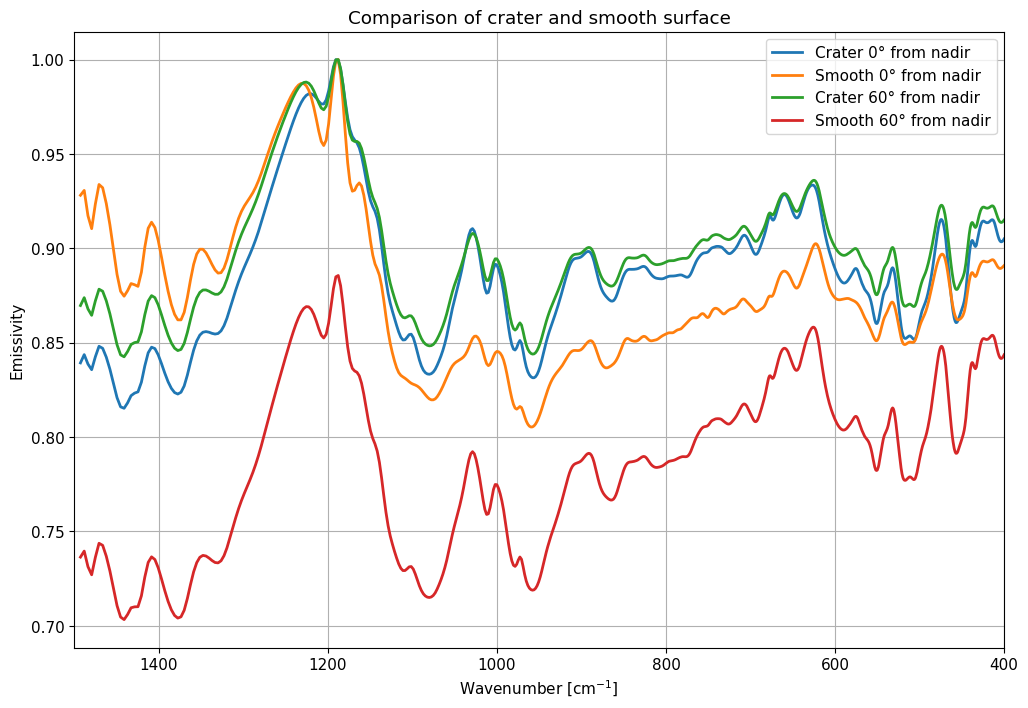

In [ ]:
crater_radiances = crater_results['radiance_thermal']
crater_wn = crater_results['wavenumbers']
smooth_radiances = smooth_results['radiance_thermal']
smooth_wn = smooth_results['wavenumbers']

wn_bounds = np.sort(np.loadtxt(sim3.cfg.wn_bounds_out))


for i, angle in enumerate([0,60]):
    crater_rad = crater_radiances[i, :, -1]
    smooth_rad = smooth_radiances[i, :, -1]
    
    # Calculate blackbody fit for this angle's radiance
    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim3, wn_bounds, crater_rad)
    crater_emiss = crater_rad / B_fit    

    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim3, wn_bounds, smooth_rad)
    smooth_emiss = smooth_rad / B_fit    

    
    # Plot normalized emissivity spectrum
    plt.plot(wn,crater_emiss, 
             label=f'Crater {angle:.0f}° from nadir', linewidth=2,linestye='--')
    plt.plot(wn,smooth_emiss, 
             label=f'Smooth {angle:.0f}° from nadir', linewidth=2)
    

plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Emissivity')
plt.title(f'Comparison of crater and smooth surface')
plt.legend()
plt.grid(True)
plt.xlim([400, 1500])
plt.gca().invert_xaxis()
plt.show()

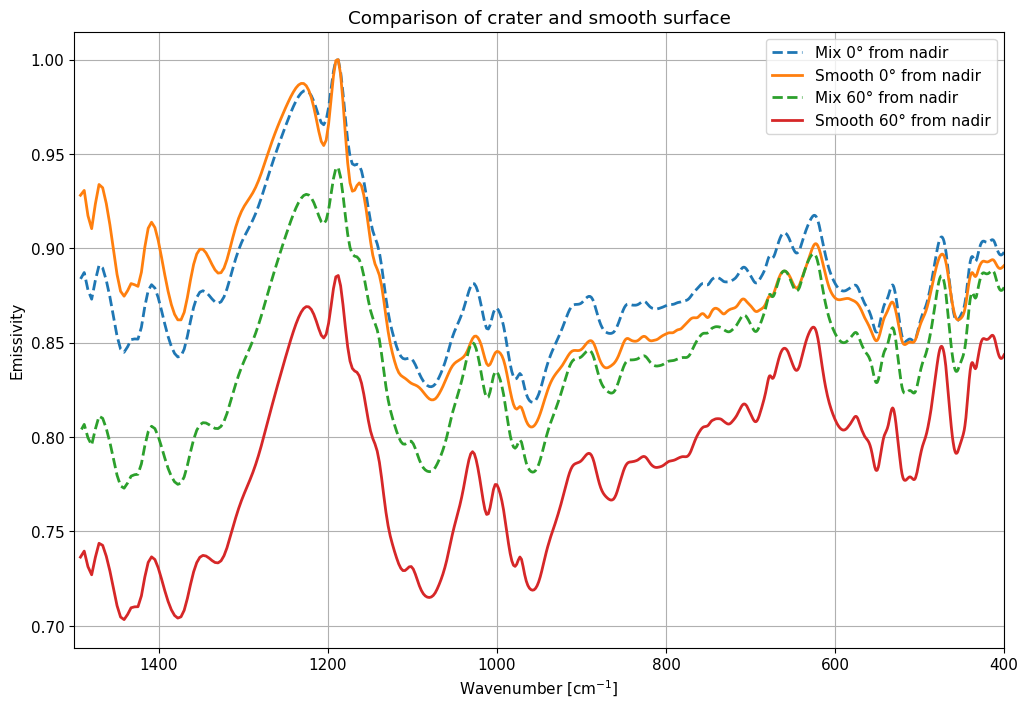

In [36]:
for i, angle in enumerate([0,60]):
    crater_rad = crater_radiances[i, :, -1]
    smooth_rad = smooth_radiances[i, :, -1]
    
    # Calculate blackbody fit for this angle's radiance
    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim3, wn_bounds, crater_rad)
    crater_emiss = crater_rad / B_fit    

    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim3, wn_bounds, smooth_rad)
    smooth_emiss = smooth_rad / B_fit    

    
    # Plot normalized emissivity spectrum
    plt.plot(wn,(crater_emiss + smooth_emiss)/2., 
             label=f'Mix {angle:.0f}° from nadir', linewidth=2,linestyle='--')
    plt.plot(wn,smooth_emiss, 
             label=f'Smooth {angle:.0f}° from nadir', linewidth=2)
    

plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Emissivity')
plt.title(f'Comparison of crater and smooth surface')
plt.legend()
plt.grid(True)
plt.xlim([400, 1500])
plt.gca().invert_xaxis()
plt.show()

## Crater case (non-isothermal)

In [30]:
settings['T_fixed'] = False
settings['crater'] = True
config4 = config_manager.create_config(settings)

# Run simulation
sim4 = Simulator(config4)
T_out4, phi_vis4, phi_therm4, T_surf4, t_out4 = sim4.run()

print(f"Simulation completed! Output shape: {T_out1.shape}")
print(f"Time range: {t_out1[0]:.0f} to {t_out1[-1]:.0f} seconds")
print(f"Surface temperature range: {T_surf1.min():.1f} to {T_surf1.max():.1f} K")

print("Computing crater radiance using ")
observer_vectors = [[0, 0, 1], [1.0, 0, 0.58]]  # 60° emission angle. 
crater_results2 = calculate_radiances_from_results(
    sim4, surface_type='crater', observer_vectors=observer_vectors
)

smooth_results2 = calculate_radiances_from_results(
    sim4, surface_type='smooth', observer_angles = [0,60]
)

print(f"Crater radiance calculation completed!")
print(f"Result keys: {list(crater_results.keys())}")
if 'radiance_thermal' in crater_results:
    print(f"Shape: {crater_results['radiance_thermal'].shape}")
    print(f"Observer angles: {crater_results['observer_angles_deg']}°")

Time step: 0.000537 s, Steps per day: 28773521
Crater effective albedo and emissivity: 0.0 0.7484655224825796
Non-diurnal step 0, time=0.00s
[Steady-state check] step 200, max |T - T_ext| = 3.431e-01 K
[Steady-state check] step 400, max |T - T_ext| = 2.540e-01 K
[Steady-state check] step 600, max |T - T_ext| = 2.201e-01 K
[Steady-state check] step 800, max |T - T_ext| = 1.907e-01 K
[Steady-state check] step 1000, max |T - T_ext| = 1.654e-01 K
Non-diurnal step 1000, time=0.54s
[Steady-state check] step 1200, max |T - T_ext| = 1.545e-01 K
[Steady-state check] step 1400, max |T - T_ext| = 1.443e-01 K
[Steady-state check] step 1600, max |T - T_ext| = 1.348e-01 K
[Steady-state check] step 1800, max |T - T_ext| = 1.260e-01 K
[Steady-state check] step 2000, max |T - T_ext| = 1.177e-01 K
Non-diurnal step 2000, time=1.07s
[Steady-state check] step 2200, max |T - T_ext| = 1.101e-01 K
[Steady-state check] step 2400, max |T - T_ext| = 1.028e-01 K
[Steady-state check] step 2600, max |T - T_ext| = 1

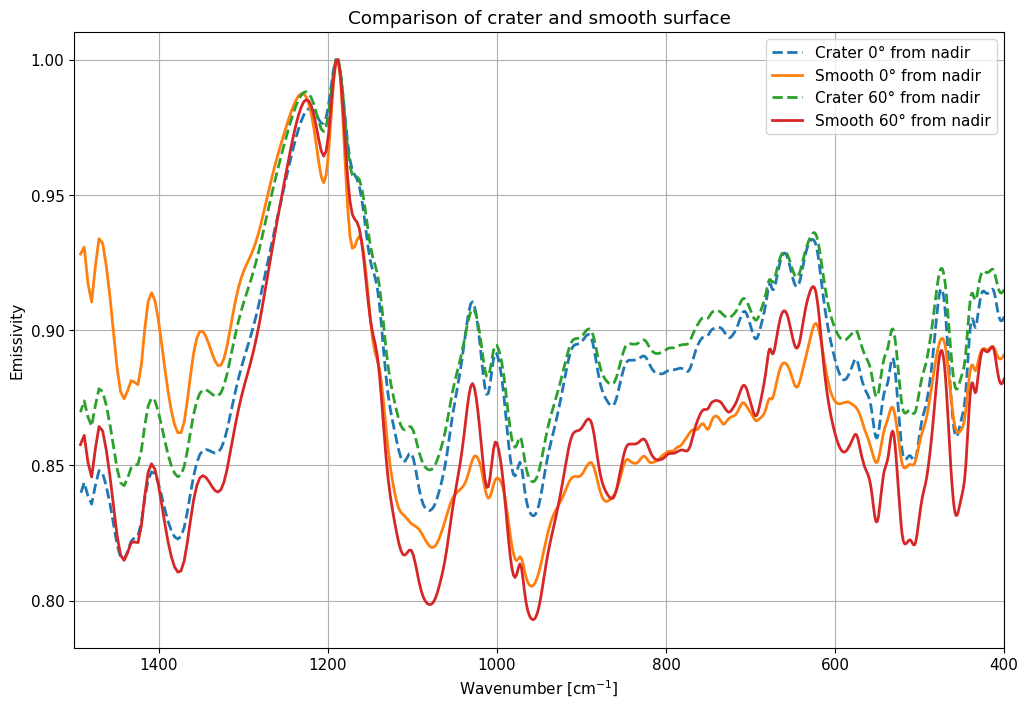

In [35]:
crater_radiances = crater_results2['radiance_thermal']
crater_wn = crater_results2['wavenumbers']
smooth_radiances = smooth_results2['radiance_thermal']
smooth_wn = smooth_results2['wavenumbers']

wn_bounds = np.sort(np.loadtxt(sim4.cfg.wn_bounds_out))


for i, angle in enumerate([0,60]):
    crater_rad = crater_radiances[i, :, -1]
    smooth_rad = smooth_radiances[i, :, -1]
    
    # Calculate blackbody fit for this angle's radiance
    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim4, wn_bounds, crater_rad)
    crater_emiss = crater_rad / B_fit    

    T_fit, B_fit, btemps, wn_BB = max_btemp_blackbody(sim4, wn_bounds, smooth_rad)
    smooth_emiss = smooth_rad / B_fit    

    
    # Plot normalized emissivity spectrum
    plt.plot(wn,crater_emiss, 
             label=f'Crater {angle:.0f}° from nadir', linewidth=2, linestyle='--')
    plt.plot(wn,smooth_emiss, 
             label=f'Smooth {angle:.0f}° from nadir', linewidth=2,linestyle='-')
    

plt.xlabel('Wavenumber [cm$^{-1}$]')
plt.ylabel('Emissivity')
plt.title(f'Comparison of crater and smooth surface')
plt.legend()
plt.grid(True)
plt.xlim([400, 1500])
plt.gca().invert_xaxis()
plt.show()

\n============================================================
CRATER vs SMOOTH SURFACE SPECTRAL COMPARISON
Auto-detected simulation object, extracting data...
Computing surface radiances for 2 observers and 1 time points...
  Observer 1/2 (mu=1.000, angle=0.0°)
  Observer 2/2 (mu=0.500, angle=60.0°)
Surface radiance calculation completed.


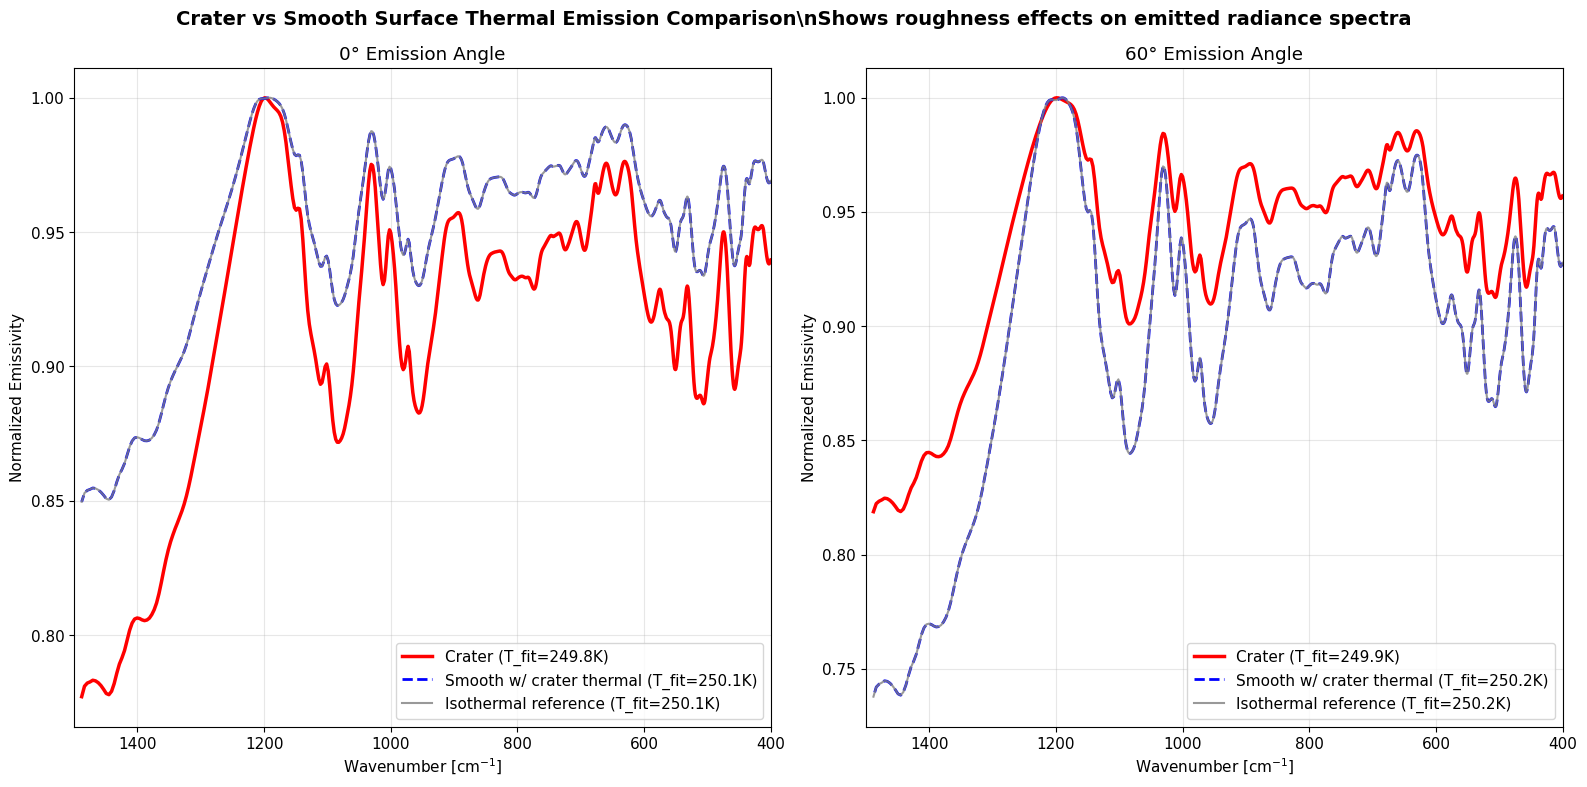

\nQuantitative Comparison Summary:
Emission Angle | Crater T_fit | Smooth T_fit | Isothermal T_fit
          0°   |     249.8K   |     250.1K   |       250.1K
         60°   |     249.9K   |     250.2K   |       250.2K
\nKey Observations:
• Crater roughness effects on spectral emission
• Angular dependence differences between crater and smooth surfaces
• Thermal profile impact on brightness temperatures
• Spectral feature variations with surface geometry


In [26]:
# Compare crater vs smooth surface thermal emission spectra
print("\\n" + "="*60)
print("CRATER vs SMOOTH SURFACE SPECTRAL COMPARISON")
print("="*60)

# Extract data for comparison plots
crater_wn = crater_results['wavenumbers']
crater_radiances = crater_results['radiance_thermal']  # [n_observers, n_waves, n_times]

# Get smooth surface results for comparison (recompute with same observer vectors for fair comparison)
smooth_results_for_comparison = calculate_radiances_from_results(
    sim3, surface_type='smooth', observer_angles=[0, 60]  # 0° and 60° emission angles
)
smooth_wn = smooth_results_for_comparison['wavenumbers'] 
smooth_radiances = smooth_results_for_comparison['radiance_thermal']

# Also get the original isothermal results for reference
iso_radiances = multi_angle_results['radiance_thermal']  # From earlier isothermal run
iso_wn = multi_angle_results['wavenumbers']

# Set up plotting parameters
ir_cutoff = np.argmin(np.abs(crater_wn - 1500))  # cm^-1 cutoff for IR
wn_bounds = np.sort(np.loadtxt(sim3.cfg.wn_bounds_out))

# Create comparison plots for 0° and 60° emission angles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

for i, angle in enumerate([0, 60]):
    ax = ax1 if i == 0 else ax2
    
    # Get radiances at final time step
    crater_rad = crater_radiances[i, :, -1]  # Crater
    smooth_rad = smooth_radiances[i, :, -1]  # Smooth surface with crater thermal profile
    
    # Get corresponding isothermal radiance (find closest angle)
    iso_angle_idx = np.argmin([abs(a - angle) for a in multi_angle_results['observer_angles_deg']])
    iso_rad = iso_radiances[iso_angle_idx, :, -1]
    
    # Calculate emissivities using blackbody fits
    T_fit_crater, B_fit_crater, _, _ = max_btemp_blackbody(sim3, wn_bounds, crater_rad)
    T_fit_smooth, B_fit_smooth, _, _ = max_btemp_blackbody(sim3, wn_bounds, smooth_rad)
    T_fit_iso, B_fit_iso, _, _ = max_btemp_blackbody(sim1, wn_bounds, iso_rad)
    
    emiss_crater = crater_rad / B_fit_crater
    emiss_smooth = smooth_rad / B_fit_smooth  
    emiss_iso = iso_rad / B_fit_iso
    
    # Normalize emissivities to same reference point
    idx1 = np.argmin(np.abs(crater_wn - 900))
    idx2 = np.argmin(np.abs(crater_wn - 1700))
    
    cf_crater = emiss_crater[idx1:idx2+1].max()
    cf_smooth = emiss_smooth[idx1:idx2+1].max()
    cf_iso = emiss_iso[idx1:idx2+1].max()
    
    # Plot normalized emissivity spectra
    ax.plot(crater_wn[:ir_cutoff], emiss_crater[:ir_cutoff] + 1 - cf_crater, 
            label=f'Crater (T_fit={T_fit_crater:.1f}K)', linewidth=2.5, color='red')
    ax.plot(smooth_wn[:ir_cutoff], emiss_smooth[:ir_cutoff] + 1 - cf_smooth,
            label=f'Smooth w/ crater thermal (T_fit={T_fit_smooth:.1f}K)', linewidth=2, color='blue', linestyle='--')
    ax.plot(iso_wn[:ir_cutoff], emiss_iso[:ir_cutoff] + 1 - cf_iso,
            label=f'Isothermal reference (T_fit={T_fit_iso:.1f}K)', linewidth=1.5, color='gray', alpha=0.8)
    
    ax.set_xlabel('Wavenumber [cm$^{-1}$]')
    ax.set_ylabel('Normalized Emissivity')
    ax.set_title(f'{angle}° Emission Angle')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([400, 1500])
    ax.invert_xaxis()

plt.suptitle('Crater vs Smooth Surface Thermal Emission Comparison\\n' + 
             'Shows roughness effects on emitted radiance spectra', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print quantitative comparison
print(f"\\nQuantitative Comparison Summary:")
print(f"Emission Angle | Crater T_fit | Smooth T_fit | Isothermal T_fit")
print(f"{'='*60}")

for i, angle in enumerate([0, 60]):
    crater_rad = crater_radiances[i, :, -1]
    smooth_rad = smooth_radiances[i, :, -1]
    iso_angle_idx = np.argmin([abs(a - angle) for a in multi_angle_results['observer_angles_deg']])
    iso_rad = iso_radiances[iso_angle_idx, :, -1]
    
    T_fit_crater, _, _, _ = max_btemp_blackbody(sim3, wn_bounds, crater_rad)
    T_fit_smooth, _, _, _ = max_btemp_blackbody(sim3, wn_bounds, smooth_rad)
    T_fit_iso, _, _, _ = max_btemp_blackbody(sim1, wn_bounds, iso_rad)
    
    print(f"{angle:11.0f}°   |   {T_fit_crater:7.1f}K   |   {T_fit_smooth:7.1f}K   |     {T_fit_iso:7.1f}K")

print(f"\\nKey Observations:")
print(f"• Crater roughness effects on spectral emission")
print(f"• Angular dependence differences between crater and smooth surfaces")
print(f"• Thermal profile impact on brightness temperatures")
print(f"• Spectral feature variations with surface geometry")

In [ ]:
# Demonstrate dual output comparison (crater vs smooth)
print("\\n" + "="*60)
print("DUAL OUTPUT DEMONSTRATION: Crater vs Smooth Surface")
print("="*60)

# Compare crater vs smooth surface at the same observer angles
dual_results = calculate_radiances_from_results(
    sim3, surface_type='both',
    observer_angles=[0, 30, 60],  # For smooth surface
    observer_vectors=[[0,0,1], [0.5,0,1], [0,0.5,1]]  # For crater surface
)

print(f"Dual calculation completed!")
print(f"Result structure: {list(dual_results.keys())}")
print(f"Smooth surface observers: {len(dual_results['smooth']['observer_angles_deg'])}")
print(f"Crater surface observers: {len(dual_results['crater']['observer_angles_deg'])}")

# This makes it very easy to compare crater vs smooth surface properties!
print("\\nEasy comparison of surface types:")
print(f"Smooth surface spectral mode: {dual_results['smooth']['spectral_mode']}")  
print(f"Crater surface spectral mode: {dual_results['crater']['spectral_mode']}")

# Show how easy it is to work with either surface type
smooth_radiances = dual_results['smooth']['radiance_thermal']
crater_radiances = dual_results['crater']['radiance_thermal'] 
print(f"Smooth radiance shape: {smooth_radiances.shape}")
print(f"Crater radiance shape: {crater_radiances.shape}")

print("\\nThis dual output makes it trivial to compare:")
print("• Directional emissivity differences")
print("• Spectral feature variations")  
print("• Angular dependencies")
print("• Temperature effects on both surface types")

In [ ]:
# Add new cell demonstrating the new radiance processor
# This cell should be added after the existing simulation

# Import the new radiance processor
from radiance_processor import calculate_radiances_from_results, recompute_radiance_with_angles

print("=== NEW RADIANCE POST-PROCESSING APPROACH ===")
print("Using the new radiance_processor module for flexible radiance computation")

# Example 1: Multiple observer angles for angular analysis
print("\nExample 1: Computing radiances for multiple observer angles")
observer_angles = [0, 15, 30, 45, 60, 75]  # degrees from nadir
print(f"Observer angles: {observer_angles}°")

# Compute radiances for all angles at once
thermal_results = (T_out2, T_surf2, t_out2)
multi_angle_results = calculate_radiances_from_results(
    thermal_results, config2, observer_angles=observer_angles
)

print(f"Computed radiances for {len(observer_angles)} observer angles")
print(f"Result structure: {list(multi_angle_results.keys())}")
if 'radiance_thermal' in multi_angle_results:
    print(f"Radiance array shape: {multi_angle_results['radiance_thermal'].shape}")
    print(f"  -> {len(multi_angle_results['observer_mus'])} observers")
    print(f"  -> {len(multi_angle_results['wavenumbers'])} wavelengths") 
    print(f"  -> {multi_angle_results['radiance_thermal'].shape[2]} time points")

# Example 2: Easy recomputation with different angles
print("\nExample 2: Recompute with different observer angles using convenience function")
new_angles = [10, 20, 40, 50]  # Different angle set
new_results = recompute_radiance_with_angles(sim2, new_angles)
print(f"Recomputed for angles: {new_angles}°")

# Example 3: Specific observer mu values (cosines)
print("\nExample 3: Direct specification of observer cosines")
mu_values = [1.0, 0.8, 0.6, 0.4, 0.2]  # From nadir to grazing
mu_results = calculate_radiances_from_results(
    thermal_results, config2, observer_mu=mu_values
)
corresponding_angles = [np.degrees(np.arccos(mu)) for mu in mu_values]
print(f"Observer mu values: {mu_values}")
print(f"Corresponding angles: {[f'{a:.1f}°' for a in corresponding_angles]}")

print("\n=== COMPARISON WITH ORIGINAL METHOD ===")
# Compare with the original approach (which now uses backward compatibility)
print("Original sim2.radiance_out shape:", sim2.radiance_out.shape)
print("New multi-angle shape:", multi_angle_results['radiance_thermal'].shape)
print("First observer (nadir) matches:", np.allclose(
    sim2.radiance_out, multi_angle_results['radiance_thermal'][0, :, :], rtol=1e-6
))